# About Dataset
###Cet ensemble de données contient des images forestières en 2 classes :

incendie : 5640 images

fumée : 12.6k images

###Les données ont été divisées en train, test et validation avec ces pourcentages :

Trains : ~75%

Essai : ~10%

validation : ~15%

Pour télécharger l'ensemble de données depuis 2 dataset du Kaggle, vous devez disposer d'un compte Kaggle.

Ensemble de données sur Kaggle :https://www.kaggle.com/datasets/kutaykutlu/forest-fire
et
https://www.kaggle.com/datasets/mohnishsaiprasad/forest-fire-images

In [2]:
import os
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/data"

Mounted at /content/drive


#load data


In [4]:
import os

def count_photos_in_folder(folder_path):
    count = sum([len(files) for _, _, files in os.walk(folder_path)])
    return count

train_smoke_path = os.path.join(path, "train_smoke")
train_fire_path = os.path.join(path, "train_fire")
test_big_path = os.path.join(path, "test_big")
test_smol_path = os.path.join(path, "test_small")

train_smoke_count = count_photos_in_folder(train_smoke_path)
train_fire_count = count_photos_in_folder(train_fire_path)
test_big_count = count_photos_in_folder(test_big_path)
test_smol_count = count_photos_in_folder(test_smol_path)

print("Number of photos in train_smoke folder:", train_smoke_count)
print("Number of photos in train_fire folder:", train_fire_count)
print("Number of photos in test_big folder:", test_big_count)
print("Number of photos in test_smol folder:", test_smol_count)

Number of photos in train_smoke folder: 12297
Number of photos in train_fire folder: 2000
Number of photos in test_big folder: 61
Number of photos in test_smol folder: 907


#Data preprocessing and Augmentation


In [ ]:
#####*****
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np

path = "/content/drive/MyDrive/data"
train_fire_path = os.path.join(path, "train_fire")

# Count the number of images in the 'train_fire' folder
num_fire_original = len(os.listdir(train_fire_path))
desired_num_fire = 2000  # Set the desired number of images for the 'train_fire' class

# Calculate the number of additional images needed
additional_images_needed = desired_num_fire - num_fire_original

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load and preprocess the images manually
fire_images = []
for img_name in os.listdir(train_fire_path):
    img_path = os.path.join(train_fire_path, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    fire_images.append(img_array)

# Convert the list of image arrays to a numpy array
fire_images_array = np.array(fire_images)

# Transpose the array to have the batch dimension first
fire_images_array = np.transpose(fire_images_array, (0, 3, 1, 2))

# Augment the images
num_generated_images = 0
for batch in datagen.flow(fire_images_array, batch_size=1, shuffle=False):
    img_array = np.transpose(batch[0], (1, 2, 0))  # Transpose back to (224, 224, 3) format
    img = image.array_to_img(img_array)
    img_path = os.path.join(train_fire_path, f"augmented_fire_{num_fire_original + num_generated_images}.jpg")
    img.save(img_path)
    num_generated_images += 1
    if num_generated_images >= additional_images_needed:
        break

# Print the total number of generated images
print("Total number of generated 'train_fire' images after augmentation:", num_generated_images)

# Update the count of images in the 'train_fire' folder
num_fire_final = len(os.listdir(train_fire_path))
print("Final number of 'train_fire' images:", num_fire_final)

##result

#Total number of generated 'train_fire' images after augmentation: 898
#Final number of 'train_fire' images: 2000

##balanced data

In [5]:

train_smoke_path = os.path.join(path, "train_smoke")
train_fire_path = os.path.join(path, "train_fire")

# List all image filenames and their labels
smoke_images = [(os.path.join(train_smoke_path, img_name), 'smoke') for img_name in os.listdir(train_smoke_path)]
fire_images = [(os.path.join(train_fire_path, img_name), 'fire') for img_name in os.listdir(train_fire_path)]

# Find the minimum number of images between smoke and fire classes
min_count = min(len(smoke_images), len(fire_images))

# Take a balanced subset of each class
balanced_images = smoke_images[:min_count] + fire_images[:min_count]

# Shuffle the list to mix the classes
import random
random.shuffle(balanced_images)

# Print the first few entries to verify
for img_path, label in balanced_images[:10]:
    print(img_path, label)
# Count the number of 'smoke' and 'fire' labels in the balanced dataset
num_smoke = sum(1 for _, label in balanced_images if label == 'smoke')
num_fire = sum(1 for _, label in balanced_images if label == 'fire')

print("Number of balanced 'smoke' data:", num_smoke)
print("Number of balanced 'fire' data:", num_fire)

/content/drive/MyDrive/data/train_smoke/011136.jpg smoke
/content/drive/MyDrive/data/train_smoke/011384.jpg smoke
/content/drive/MyDrive/data/train_smoke/010930.jpg smoke
/content/drive/MyDrive/data/train_fire/fire-3902.5385931.png fire
/content/drive/MyDrive/data/train_fire/fire-8964.53014965.png fire
/content/drive/MyDrive/data/train_smoke/012447.jpg smoke
/content/drive/MyDrive/data/train_smoke/011071.jpg smoke
/content/drive/MyDrive/data/train_fire/fire-4204.68992307.png fire
/content/drive/MyDrive/data/train_fire/fire-8447.98241792.png fire
/content/drive/MyDrive/data/train_smoke/010538.jpg smoke
Number of balanced 'smoke' data: 2000
Number of balanced 'fire' data: 2000


In [6]:
validation_list = []

def count_images_with_fire(directory):
    count = 0
    # List all files in the directory
    files = os.listdir(directory)
    # Iterate over each filename
    for filename in files:
        # Check if "fire" is present in the filename
         if "f" in filename.lower():
           image_path = os.path.join(directory, filename)
           validation_list.append((image_path, "fire"))
           count += 1
         if "smok" in filename.lower():
           image_path = os.path.join(directory, filename)
           validation_list.append((image_path, "smoke"))
           count += 1
    return count

# Example usage:
pat= os.path.join(path, "test_small")
fire_image_count = count_images_with_fire(pat)


for image_path, label in validation_list[:10]:
    print(image_path, label)

/content/drive/MyDrive/data/test_small/fire7.png fire
/content/drive/MyDrive/data/test_small/fire5.png fire
/content/drive/MyDrive/data/test_small/fire4.png fire
/content/drive/MyDrive/data/test_small/fire8.png fire
/content/drive/MyDrive/data/test_small/smoke13.png smoke
/content/drive/MyDrive/data/test_small/fire2.png fire
/content/drive/MyDrive/data/test_small/fire6.png fire
/content/drive/MyDrive/data/test_small/fire11.png fire
/content/drive/MyDrive/data/test_small/smoke12.png smoke
/content/drive/MyDrive/data/test_small/fire12.png fire


#Visualizing Training Data after Augmentation

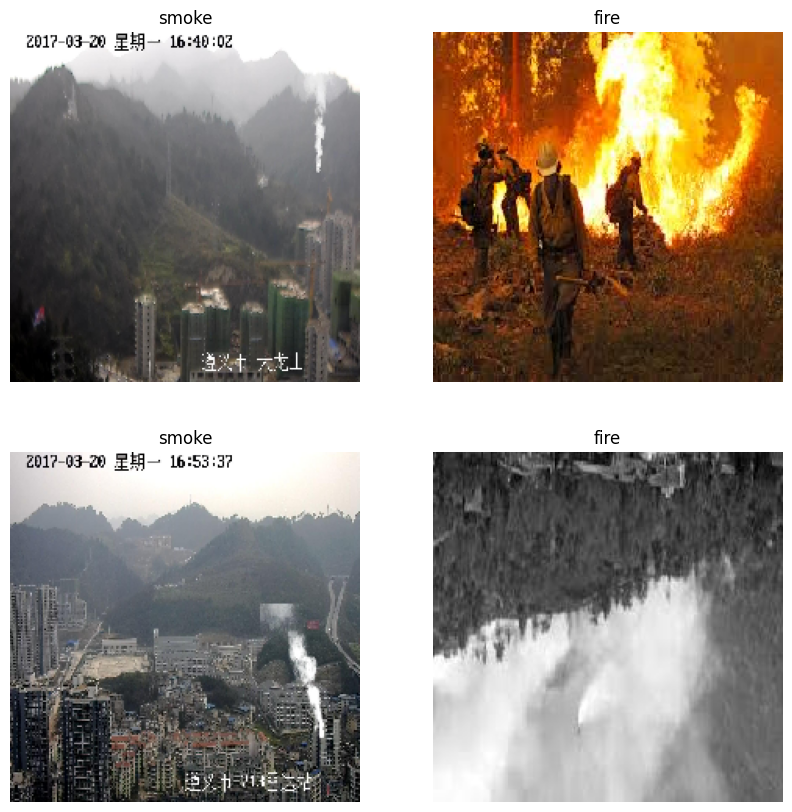

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Function to visualize sample images
def visualize_images(image_list):
    # Randomly select sample images
    sample_files = random.sample(image_list, 4)  # Select 4 random images
    # Plot sample images
    plt.figure(figsize=(10, 10))
    for i, (img_path, label) in enumerate(sample_files):
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Visualize random sample images from balanced_images
visualize_images(balanced_images)




#CNN model

In [7]:
import cv2
import numpy as np

# Define a function to load and preprocess images
def load_images(image_paths, image_size):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, image_size)  # Resize the image to the desired size
        # You may apply additional preprocessing here (e.g., normalization)
        images.append(image)
    return np.array(images)

# Define the image size you want for your model (adjust as needed)
image_size = (150, 150)  # Example size

# train
X_train_paths, y_train_labels= zip(*balanced_images)
X_train = load_images(X_train_paths, image_size)
y_train = np.array([1 if label == 'fire' else 0 for label in y_train_labels])  # Convert labels to binary (fire=1, smoke=0)


In [8]:
#validation
X_val_paths, y_val_labels = zip(*validation_list)
X_val = load_images(X_val_paths, image_size)
y_val = np.array([1 if label == 'fire' else 0 for label in y_val_labels])  # Convert labels to binary (fire=1, smoke=0)


In [9]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN model
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer, binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


#Training Model

In [10]:
!pip install tensorflow keras
from tensorflow.keras import models, layers
import tensorflow as tf

In [11]:
# Define input shape (adjust according to your image size)
input_shape = (image_size[0], image_size[1], 3)

# Create the model
model = create_model(input_shape)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
125/125 [==============================] - 227s 2s/step - loss: 2.2199 - accuracy: 0.9340 - val_loss: 0.0750 - val_accuracy: 0.9846
Epoch 2/10
125/125 [==============================] - 222s 2s/step - loss: 0.0137 - accuracy: 0.9967 - val_loss: 0.1965 - val_accuracy: 0.9813
Epoch 3/10
125/125 [==============================] - 229s 2s/step - loss: 0.0244 - accuracy: 0.9935 - val_loss: 0.0740 - val_accuracy: 0.9868
Epoch 4/10
125/125 [==============================] - 224s 2s/step - loss: 0.0265 - accuracy: 0.9958 - val_loss: 0.1040 - val_accuracy: 0.9746
Epoch 5/10
125/125 [==============================] - 224s 2s/step - loss: 0.0232 - accuracy: 0.9948 - val_loss: 0.0735 - val_accuracy: 0.9868
Epoch 6/10
125/125 [==============================] - 229s 2s/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 0.0966 - val_accuracy: 0.9868
Epoch 7/10
125/125 [==============================] - 220s 2s/step - loss: 0.0201 - accuracy: 0.9980 - val_loss: 0.0847 - val_accuracy: 0.9857

#Model Evaluation

In [13]:
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Get predictions on the validation set
y_val_pred = np.round(model.predict(X_val)).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# Calculate precision
precision = precision_score(y_val, y_val_pred)

# Calculate recall
recall = recall_score(y_val, y_val_pred)

# Calculate F1-Score
f1 = f1_score(y_val, y_val_pred)

# Calculate Specificity
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity = tn / (tn + fp)


# Calculate AUC
auc = roc_auc_score(y_val, y_val_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Specificity: {specificity}")
print(f"AUC: {auc}")


29/29 [==============================] - 14s 491ms/step
Accuracy: 0.9856670341786108
Precision: 0.9799666110183639
Recall: 0.9982993197278912
F1-Score: 0.9890480202190397
Specificity: 0.9623824451410659
AUC: 0.9803408824344785


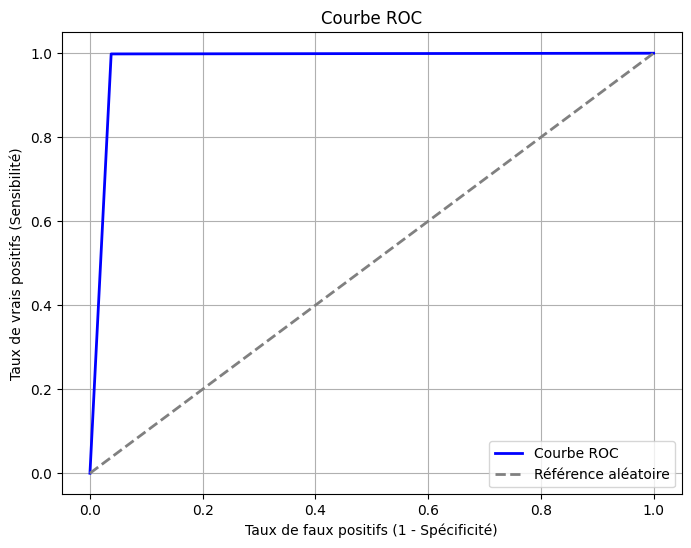

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcul des valeurs de sensibilité et de spécificité pour différents seuils
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Référence aléatoire')
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC')
plt.legend()
plt.grid(True)
plt.show()


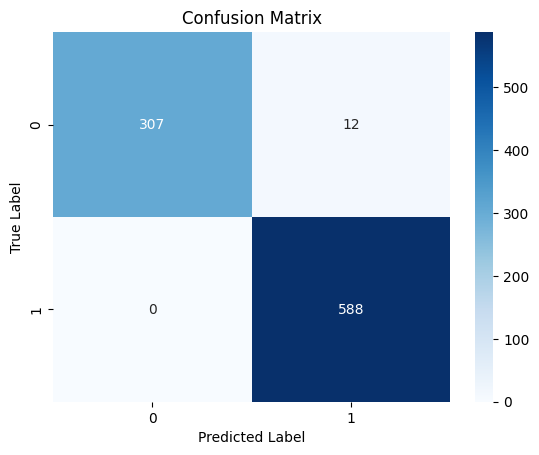

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val,y_val_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Save model

In [ ]:


model_name = "fire_smoke_model"
save_path = "/content/drive/MyDrive/data/"  # Example directory
model.save(f'{save_path}{model_name}.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test


In [15]:
test_list = []

def count_images_with_fire(directory):
    count = 0
    # List all files in the directory
    files = os.listdir(directory)
    # Iterate over each filename
    for filename in files:
        # Check if "fire" is present in the filename
         if "f" in filename.lower():
           image_path = os.path.join(directory, filename)
           test_list.append((image_path, "fire"))
           count += 1
         if "smok" in filename.lower():
           image_path = os.path.join(directory, filename)
           test_list.append((image_path, "smoke"))
           count += 1
    return count

# Example usage:
pat_test= os.path.join(path, "test_big")
fire_image_count_test = count_images_with_fire(pat_test)


for image_path, label in test_list[:10]:
    print(image_path, label)

/content/drive/MyDrive/data/test_big/F_14.jpg fire
/content/drive/MyDrive/data/test_big/F_12.jpg fire
/content/drive/MyDrive/data/test_big/F_11.jpg fire
/content/drive/MyDrive/data/test_big/F_13.jpg fire
/content/drive/MyDrive/data/test_big/F_0.jpg fire
/content/drive/MyDrive/data/test_big/F_1.jpg fire
/content/drive/MyDrive/data/test_big/F_15.jpg fire
/content/drive/MyDrive/data/test_big/F_10.jpg fire
/content/drive/MyDrive/data/test_big/F_23.jpg fire
/content/drive/MyDrive/data/test_big/F_2.jpg fire


In [16]:
# test
X_test_paths, y_test_labels= zip(*test_list)
X_test = load_images(X_test_paths, image_size)
y_test = np.array([1 if label == 'fire' else 0 for label in y_test_labels])  # Convert labels to binary (fire=1, smoke=0)


In [17]:
import numpy as np

from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/data/fire_smoke_model.h5")
# Make predictions on the test data using your model
y_pred_prob = model.predict(X_test)  # Predict probabilities
y_pred = np.round(y_pred_prob).flatten()  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the model
# For example, calculate accuracy
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy: {accuracy}")


2/2 [==============================] - 1s 416ms/step
Accuracy: 0.9523809523809523


In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model("/content/drive/MyDrive/data/fire_smoke_model.h5")

# Prédictions sur l'ensemble de test
y_test_pred_prob = model.predict(X_test)  # Prédire les probabilités
y_test_pred = np.round(y_test_pred_prob).flatten()  # Convertir les probabilités en prédictions binaires (0 ou 1)

# Calculer les métriques
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)

# Calculer l'AUC
auc = roc_auc_score(y_test, y_test_pred)

# Afficher les métriques
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Specificity: {specificity}")
print(f"AUC: {auc}")


2/2 [==============================] - 1s 403ms/step
Accuracy: 0.9523809523809523
Precision: 0.967741935483871
Recall: 0.9375
F1-Score: 0.9523809523809523
Specificity: 0.967741935483871
AUC: 0.9526209677419355


2/2 [==============================] - 1s 396ms/step


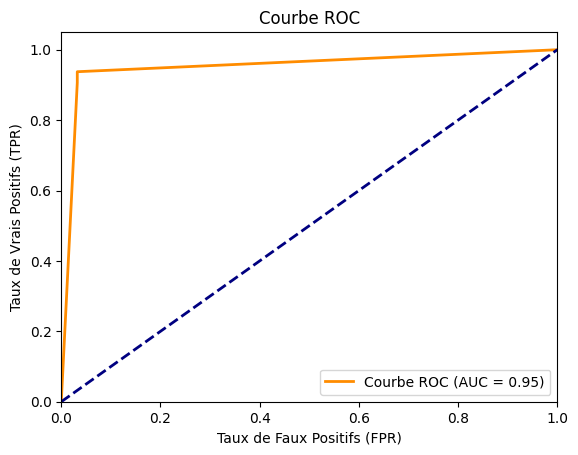

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model("/content/drive/MyDrive/data/fire_smoke_model.h5")

# Prédictions sur l'ensemble de test
y_test_pred_prob = model.predict(X_test)  # Prédire les probabilités

# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils à l'aide des prédictions de probabilité
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


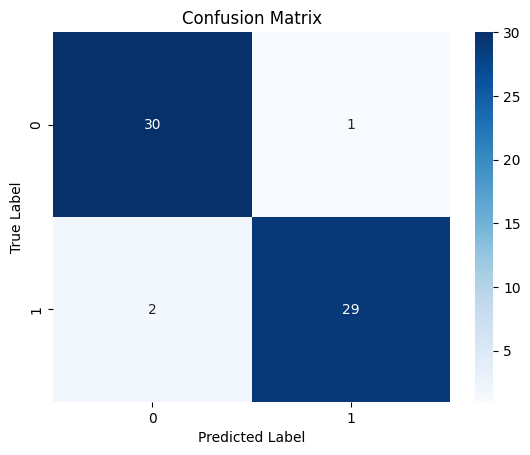

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix_test = confusion_matrix(y_test,y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#using vidios

In [ ]:
import cv2
import os

# Path to the video file
video_path = "/content/drive/MyDrive/data/Fire _VIDEO.mp4"

# Directory to save the extracted frames
output_dir = "/content/drive/MyDrive/data/test_vid"
# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frame rate of the video
frame_rate = cap.get(cv2.CAP_PROP_FPS)

# Initialize variables
frame_count = 0
seconds_per_frame = 1 / frame_rate

# List to store the paths of extracted frames
test_video = []

# Iterate through the video frames
while cap.isOpened():
    # Read the next frame
    ret, frame = cap.read()

    # Break the loop if no frame is retrieved
    if not ret:
        break

    # Check if it's time to capture the frame
    if frame_count % round(frame_rate) == 0:
        # Save the frame as a PNG image file
        frame_name = f"frame_{frame_count}.png"
        frame_path = os.path.join(output_dir, frame_name)
        cv2.imwrite(frame_path, frame, [cv2.IMWRITE_PNG_COMPRESSION, 0])  # Use compression level 0 for lossless PNG

        # Append the path to the list
        test_video.append(frame_path)

    # Increment frame counter
    frame_count += 1

# Release the video capture object
cap.release()

# Print the list of paths
for path in test_video:
    print(path)


/content/drive/MyDrive/data/test_vid/frame_0.png
/content/drive/MyDrive/data/test_vid/frame_30.png
/content/drive/MyDrive/data/test_vid/frame_60.png
/content/drive/MyDrive/data/test_vid/frame_90.png
/content/drive/MyDrive/data/test_vid/frame_120.png
/content/drive/MyDrive/data/test_vid/frame_150.png
/content/drive/MyDrive/data/test_vid/frame_180.png
/content/drive/MyDrive/data/test_vid/frame_210.png
/content/drive/MyDrive/data/test_vid/frame_240.png
/content/drive/MyDrive/data/test_vid/frame_270.png
/content/drive/MyDrive/data/test_vid/frame_300.png
/content/drive/MyDrive/data/test_vid/frame_330.png
/content/drive/MyDrive/data/test_vid/frame_360.png
/content/drive/MyDrive/data/test_vid/frame_390.png
/content/drive/MyDrive/data/test_vid/frame_420.png
/content/drive/MyDrive/data/test_vid/frame_450.png
/content/drive/MyDrive/data/test_vid/frame_480.png
/content/drive/MyDrive/data/test_vid/frame_510.png
/content/drive/MyDrive/data/test_vid/frame_540.png
/content/drive/MyDrive/data/test_vid

In [ ]:

#  test video images
X_test_vid = load_images(test_video, image_size)


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/data/fire_smoke_model.h5")

# Make predictions on the test data using your model
y_pred_vid = model.predict(X_test_vid)  # Predict probabilities
y_pred_vid = np.round(y_pred_vid).flatten()  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the model
print(y_pred_vid)
# Print binary predictions

if 1 in y_pred_vid:
    print("Alert: Fire detected!")
else:
    print("No fire detected.")




1/1 [==============================] - 1s 751ms/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Alert: Fire detected!
